In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

sns.set(style="white")

In [2]:
data_source_dir = r"K:\Projects\sarawak_energy\data"
output_source_dir = r"K:\Projects\sarawak_energy\output"
plot_dir = r"K:\Projects\sarawak_energy\plots"

In [3]:
def GetFile(file, directory=data_source_dir):
    return os.path.join(directory, file)

In [4]:
xls = pd.ExcelFile(GetFile("sarawak_energy.xlsx"))

In [5]:
xls.sheet_names

['Consumption_Point_Data_Package',
 'parameters',
 'Occurrencies_Data_Package',
 'Billing_Data_Package']

In [6]:
df_dict = {}
for sheet_name in xls.sheet_names:
    df_dict[sheet_name] = xls.parse(sheet_name)

In [7]:
class LazyDict(dict):
    def keylist(self, keys, value):
        for key in keys:
            self[key] = value
    
    @staticmethod
    def add_to_dict(comps_list):
        for comps in comps_list:
            try:
                component_dict.keylist(comps[0], comps[1])
            except:
                print(comps)

In [8]:
comps_list = [
    # prioritize components
    [['illegal', 'tampering', 'teampering'], 'illegal and tampering'],
    [['inspect','insp', 'inspection','inpection','check', 'checking', 'checked'], 'inspection'],
    [['disconnect','disconnected', 'disconnection'], 'disconnect'], 
    [['read', 'reading'], 'reading'],
    [['arrears'], 'arrears'],
    [['displ', 'display'], 'no display'],
    [['change', 'replac', 'replace', 'replaced', 'replacement', 'replacment'], 'changing'],
    [['faulty'], 'faulty'],
    [['install', 'installation','new move in'], 'installing'],
    [['jammed'], 'jamming'],
    [['operation', 'opps', 'ops'], 'operating'],
    [[ 'replac', 'replace', 'replaced', 'replacement', 'replacment'], 'replacing'],
    [['reconnect', 'reconnection'], 'reconnecting'],
    [[ 'retest', 'retesting', 'test', 'testing'], 'testing'],
    [['upgrade', 'upgrading'], 'upgrading'],
    [['missing'], 'missing']
    
]

In [9]:
component_dict = LazyDict()
component_dict.add_to_dict(comps_list)

In [10]:
def add_component(description, component_dict):
    for comp in component_dict:
        if comp in description:
            return component_dict[comp]

    return "other"

In [11]:
def cleanse_df_cp(df_cp):
    
    non_null_cols = df_cp.isna().all()[df_cp.isna().all()==False].index.tolist()
    df_cp = df_cp[non_null_cols]
    df_cp.drop(["MoveIn", "MoveOut", "billing_factor"], inplace=True, axis = 1)
    
    df_cp["was_fraud"] = df_cp["was_fraud"].replace("S", 1)
    df_cp["was_fraud"] = df_cp["was_fraud"].replace(np.nan, 0)
    df_cp["was_fraud"] = df_cp["was_fraud"].astype(int)
    
    df_cp.rename(columns={'id':'id_uc'}, inplace=True)
    
    return df_cp

In [12]:
def spell_correct(description):
    
    description = description.lower()
    
    # remove numbers and special characters
    description = re.sub('[' + string.punctuation + '0-9\\r\\t\\n]', ' ', description)
    #description = TextBlob(description)
    #description = str(description.correct())
    
    return description

In [13]:
def cleanse_df_op(df_op):
    
    non_null_cols = df_op.isna().all()[df_op.isna().all()==False].index.tolist()

    df_op = df_op[non_null_cols]
    
    df_op["Desc"] = df_op["Desc"].apply(spell_correct)
    
    df_op["activity"] = df_op["Desc"].apply(add_component, component_dict=component_dict)
    
    return df_op

In [14]:
def cleanse_df_bp(df_bp):
    
    non_null_cols = df_bp.isna().all()[df_bp.isna().all()==False].index.tolist()

    df_bp = df_bp[non_null_cols]
    
    # replacing the nans with zeros
    df_bp.replace(np.nan, 0.0, inplace=True)
    
    return df_bp

In [15]:
def cleanse_df(df_dict):
    
    df_cp = cleanse_df_cp(df_dict['Consumption_Point_Data_Package'])
    
    df_op = cleanse_df_op(df_dict['Occurrencies_Data_Package'])
    
    df_bp = cleanse_df_bp(df_dict['Billing_Data_Package'])
    
    months_count =df_bp.groupby(['id_uc']).count()['date_reference'].reset_index()
    customers_filtered = list(months_count.query('date_reference >= 6')['id_uc'].unique())
    df_cp_filtered = df_cp[df_cp["id_uc"].isin(customers_filtered)]
    df_op_filtered = df_op[df_op["id_uc"].isin(customers_filtered)]
    df_bp_filtered = df_bp[df_bp["id_uc"].isin(customers_filtered)]
    
    return df_cp, df_op, df_bp

# Feature Engineering

There are mainly two types of features we can use which are the **Time Series Features** and the **Categorical Features**

## Time Series Features

Explained below

## Categorical Features

Number of checkings, etc..

## Pilot

* column for negative values
* remove negative values
* data normalization using min max scaler per customer
* Remove rows with less than 6 months data
* Dump it onto tsfresh first

## Features

### Paper 1
* Average consumption of last x months
* Maximum consumption of last x months
* Stdev consumption of last x months
* Number of inspection remarks last x months or suspect tampering
* Average consumption of residential area

### Paper 2
* Abrupt decrease in consumption
* Long period of low consumption compared to average
* Consumption discrepancy
* Consumption peak - Consumption in a month x% times higher/lower than
the previous and the following month.
* Billing/consumption similarity - (only in gas)
* Unknown consumption - Number of consecutive estimated readings, consecutive 0 or NULL consumption (in the present and historically)
* Negative Consumption - Whether the customer has a negative consumption (e.g. count was reset at the installation of a new meter)
* Reading correction, reset, or suspected tampering

# Further filtering

Filter out the following:

## Customers with less than 6 points of data
* 5% of customers removed
* 2 fraud customers were removed, remaining is 48
* 16 non-fraud customers were removed, 285 remaining

# Feasibility test

## Further issues with time series
* Discontinuous time series (not continuous)
* NULL values
* Multiple readings in a month
* Negative meter reading - meter reset
* Zero value - estimated reading
* How to compare with average ? - local ? set fixed time points ?
* Missing months in between

## ToDo

* Solve time series problems of discontinuity 
* Groupby resample mean
* Compute new set of features 
* Remember to compute using **% percentage drop** as need to normalize
* Consider normalizing data (global or local)

* Compute long time series from average
* Think of ways to capture the drops 

In [16]:
import datetime

In [17]:
def last_day(d):
    
    last = datetime.date(d.year + d.month // 12, d.month % 12 + 1, 1) - datetime.timedelta(1)
    return pd.to_datetime(last)
    

In [18]:
df_cp_filtered, df_op_filtered, df_bp_filtered = cleanse_df(df_dict)

k:\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
k:\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
k:\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

# Time Series Features

* Format date to last day of month
* Resample time series by monthly mean
* Replace the NaNs as 0

In [19]:
y = df_cp_filtered[['id_uc', 'was_fraud']].drop_duplicates('id_uc', keep='last').sort_values(['id_uc'])

df_bp_ts = df_bp_filtered.sort_values(['id_uc', 'date_reference']).drop(['date_measured', 'ReadType'], axis=1)

assert (len(y) == len(df_bp_ts['id_uc'].unique())), print("unique elements do not match")

In [20]:
df_bp_ts['date_reference'] = df_bp_ts['date_reference'].apply(last_day)

In [21]:
df_bp_ts.reset_index(drop=True, inplace=True)

In [22]:
df_bp_ts = df_bp_ts.groupby('id_uc').resample('M', on="date_reference").mean()
df_bp_ts = df_bp_ts.drop(['id_uc'], axis=1).reset_index()

In [23]:
df_bp_ts = df_bp_ts.replace(np.NaN, 0)

In [24]:
df_bp_ts.groupby('id_uc').size().sort_values().to_frame().merge(y, on='id_uc', how='inner').head()

id_uc  0  was_fraud
0  100000420500  1          0
1  100004246105  1          0
2  100004951410  1          0
3  100004827990  1          0
4  100002452620  2          0

In [25]:
df_bp_ts.head()

id_uc date_reference    Read  Billed  consumption_invoiced  \
0  100000023146     2016-08-31     0.0     0.0                   0.0   
1  100000023146     2016-09-30     0.0     0.0                   0.0   
2  100000023146     2016-10-31  3009.0  3009.0                3009.0   
3  100000023146     2016-11-30  5015.0  5015.0                2006.0   
4  100000023146     2016-12-31  7021.0  7021.0                2006.0   

   consumption_measured  value_measured  
0                   0.0             0.0  
1                   0.0             0.0  
2                3009.0          3009.0  
3                2006.0          5015.0  
4                2006.0          7021.0

In [26]:
from itertools import groupby

def len_iter(items):
    return sum(1 for _ in items)

def consecutive_zero(data):
    x = list((len_iter(run) for val, run in groupby(data) if val==0))
    if len(x)==0: return 0 
    else: return max(x)
    
def consecutive_negative(data):
    x = list((len_iter(run) for val, run in groupby(data) if val<0))
    if len(x)==0: return 0 
    else: return max(x)
    
def consecutive_low(data):
    x = list((len_iter(run) for val, run in groupby(data) if val==True))
    if len(x)==0: return 0 
    else: return max(x)
    
def cleanse_ts(ts):
    
    try:
        ts = ts.mask(ts <= 0, np.nan).interpolate(limit_direction='both')
    except:
        return np.NaN

    return ts

def cleanse_ts_series(ts):
    
    try:
        ts = ts.mask(ts <= 0, np.nan).interpolate(limit_direction='both')
    except:
        return np.NaN

    return ts

def sharp_drops_count(ts, series=False):
    a = .7

    try:
        d = pd.Series(ts.values[1:] - ts.values[:-1], index=ts.index[:-1]).abs()
        r = d.rolling(3, min_periods=1, win_type='parzen').sum()
        n = r.max()
    except:
        return np.NaN
    
    if series:
        return (r > n* a)
    else:
        return sum(r > n * a)

def highest_con_dif(ts):
    
    try:
        hcd = abs(min(ts - ts.shift(-1) ) / np.mean(ts))
    
    except:
        return np.NaN
    
    return hcd

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

In [27]:
def ts_feature_engineering(df):
    """
    Function for feature engineering of time series. Those that involves counts are expressed in %
    """
    # number of records
    records = int(len(df))
    
    # negatives represent a meter was reset
    negatives = np.mean(df['consumption_measured'] < 0) 
    
    # number of zeros in the ts. Zeros represent unknown or estimated figure
    zeros = np.mean(df['consumption_measured'] == 0) 
    
    # consecutive zeros percentage in consumption measured, consecituve zeros / number of records
    #https://stackoverflow.com/questions/51605651/find-longest-run-of-consecutive-zeros-for-each-user-in-dataframe
    consecutive_zeros = consecutive_zero(df['consumption_measured']) / records
    
    # consumption measured != consumption billed and consumption measured is positive
    consumption_difference = sum(df[df['consumption_invoiced']!=df['consumption_measured']]['consumption_measured']>0) / records
    
    # features that needs a cleansed time series
    ts = cleanse_ts(df['consumption_measured'])
    
    # sharp drop count
    sdc = sharp_drops_count(ts) / records
    
    # number of low periods count
    lpc = consecutive_low( sharp_drops_count(ts, True)) / records
    # number of peaks
    
    
    # highest consecutive difference / average 
    hcd = highest_con_dif(ts)
    
    # vs average of region, locality, municipality
    # MAPE vs municipality
    ts_local = df.set_index('date_reference').apply(cleanse_ts)[['id_uc', 'consumption_measured']].reset_index().merge(locations, on='id_uc', how='left')
    ts_local = ts_local.merge(locations_ts['id_locality'], on=['id_locality', 'date_reference'])
    mapd_local = mean_absolute_percentage_error(ts_local['consumption_measured_x'], ts_local['consumption_measured_y'])
    
    series_dict = {'records':records ,'negatives':negatives, 'zeros':zeros, 
                   'consecutive_zeros': consecutive_zeros, 'consumption_difference': consumption_difference,
                   'sharp_drop': sdc, 'consecutive_low': lpc, 'highest_con_diff': hcd, 'mapd_local': mapd_local
                  
                  }
    
    
    return pd.Series(series_dict)

In [28]:
locations = df_cp_filtered[['id_uc', 'id_region','id_locality', 'id_municipality']].drop_duplicates('id_uc', keep='last').sort_values(['id_uc'])

main_ts = df_bp_ts[['id_uc', 'date_reference', 'consumption_measured']].set_index('date_reference').groupby('id_uc').apply(cleanse_ts).reset_index()

main_ts = main_ts.merge(locations, on='id_uc', how='left')

locations_ts = {}

for location in ['id_region', 'id_locality', 'id_municipality']:
    
    locations_ts[location] = main_ts[['date_reference', 'consumption_measured', 'id_region', 'id_locality', 'id_municipality']].groupby([location]).resample('M', on="date_reference").mean().drop(['id_region'], axis=1).reset_index()

In [29]:
df_bp_ts['id_uc_2'] = df_bp_ts['id_uc'].copy()

In [30]:
ts_features = df_bp_ts.groupby('id_uc_2').apply(ts_feature_engineering)
ts_features = ts_features.reset_index().rename(columns={'id_uc_2':'id_uc'})

In [31]:
ts_features['id_uc'] = ts_features['id_uc'].astype(str)

In [32]:
ts_features.head()

id_uc  records  negatives     zeros  consecutive_zeros  \
0  100000023146     26.0   0.038462  0.115385           0.076923   
1  100000106908     89.0   0.011236  0.022472           0.011236   
2  100000328929    183.0   0.016393  0.158470           0.005464   
3  100000420500      1.0   0.000000  1.000000           1.000000   
4  100000597035    129.0   0.000000  0.449612           0.224806   

   consumption_difference  sharp_drop  consecutive_low  highest_con_diff  \
0                0.000000    0.115385         0.038462          0.599139   
1                0.000000    0.044944         0.022472          0.837240   
2                0.005464    0.005464         0.005464          8.911044   
3                0.000000    0.000000         0.000000               NaN   
4                0.000000    0.007752         0.007752          2.042415   

   mapd_local  
0    2.482151  
1    3.285958  
2    1.298429  
3         NaN  
4    0.000000

# Categorical Features

* Convert the <span class="girk">categorical activity column into a count</span> column by casting

In [33]:
agg_cat = df_op_filtered.sort_values(['id_uc', 'date_created']).groupby(['id_uc', 'activity']).size().to_frame().reset_index()

In [34]:
agg_cat_size = df_op_filtered.sort_values(['id_uc', 'date_created']).groupby('id_uc').size().to_frame().reset_index()

In [35]:
agg_cat_size.rename(columns={0:'total activities'}, inplace=True)

In [36]:
agg_cat.rename(columns={0:"count"}, inplace=True)

In [37]:
agg_cat = agg_cat.pivot(index='id_uc', columns='activity', values='count').reset_index()

agg_cat.columns.name = None
agg_cat.rename(columns={'other':'other total activities'}, inplace=True)
agg_cat.replace(np.NaN, 0, inplace=True)

In [38]:
#agg_cat = agg_cat.merge(agg_cat_size, on='id_uc', how='inner')

In [43]:
agg_cat['id_uc'] = agg_cat['id_uc'].astype(str)

In [44]:
agg_cat.shape

(313, 18)

In [45]:
ts_features.shape

(350, 10)

In [46]:
agg_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_uc                   313 non-null    object 
 1   arrears                 313 non-null    float64
 2   changing                313 non-null    float64
 3   disconnect              313 non-null    float64
 4   faulty                  313 non-null    float64
 5   illegal and tampering   313 non-null    float64
 6   inspection              313 non-null    float64
 7   installing              313 non-null    float64
 8   jamming                 313 non-null    float64
 9   missing                 313 non-null    float64
 10  no display              313 non-null    float64
 11  operating               313 non-null    float64
 12  other total activities  313 non-null    float64
 13  reading                 313 non-null    float64
 14  reconnecting            313 non-null    fl

# Merge both TS and Categorical count features

In [47]:
df = ts_features.merge(agg_cat, on="id_uc", how="left")

In [48]:
cat_features = ['arrears', 'changing', 'disconnect', 'faulty',
       'illegal and tampering', 'inspection', 'installing', 'jamming',
       'missing', 'no display', 'operating', 'other total activities', 'reading',
       'reconnecting', 'replacing', 'testing', 'upgrading']

In [49]:
# labels = df_cp_filtered[['id_uc', 'was_fraud', 'id_uc_aggregated_class', 'id_uc_class', 'id_uc_contract_situation',
#        'id_uc_meter_brand']].drop_duplicates('id_uc', keep='last').sort_values(['id_uc'])

labels = df_cp_filtered[['id_uc', 'was_fraud']].drop_duplicates('id_uc', keep='last').sort_values(['id_uc'])

labels['id_uc'] = labels['id_uc'].astype(str)

#labels = pd.get_dummies(labels.set_index(['id_uc', 'was_fraud'])).reset_index()

In [50]:
df = df.merge(labels, on="id_uc", how="inner")

In [51]:
df[cat_features] = df[cat_features].replace(np.NaN, 0)

In [53]:
df.to_csv('jason_training_full.csv', index=False)

# XGBOOST

In [47]:
import xgboost as xgb
import shap
import matplotlib.pylab as pl
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, f1_score, precision_score, roc_curve, auc
from sklearn.metrics import recall_score, roc_auc_score, precision_recall_curve, confusion_matrix

In [48]:
shap.initjs()

In [49]:
predictors = df.columns.tolist()

In [50]:
predictors.remove('id_uc')
predictors.remove('was_fraud')
#predictors.remove('other')

In [51]:
predictors

['records',
 'negatives',
 'zeros',
 'consecutive_zeros',
 'consumption_difference',
 'sharp_drop',
 'consecutive_low',
 'highest_con_diff',
 'mapd_local',
 'arrears',
 'changing',
 'disconnect',
 'faulty',
 'illegal and tampering',
 'inspection',
 'installing',
 'jamming',
 'missing',
 'no display',
 'operating',
 'other total activities',
 'reading',
 'reconnecting',
 'replacing',
 'testing',
 'upgrading']

In [52]:
ids = df['id_uc']
X = df[['id_uc'] + predictors]
y = df['was_fraud']

In [53]:
sps = y.value_counts()[0]/y.value_counts()[1]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)
X_train_cp = X_train.copy()
X_test_cp = X_test.copy()
X_train.drop('id_uc', axis=1, inplace=True)
X_test.drop('id_uc', axis=1, inplace=True)
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

#d_whole = xgb.DMatrix(X, label=y)

k:\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [55]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "max_depth": 7,
    "eval_metric": "logloss",
    "scale_pos_weight": sps,
    "n_jobs": -1,
    "silent": 1,
    "seed": 2147
}
results = {}

model = xgb.train(params, d_train, 1000, evals = [(d_train, "train"), (d_test, "test")], verbose_eval=100, early_stopping_rounds=100, evals_result=results)

[0]	train-logloss:0.684826	test-logloss:0.685792
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.26091	test-logloss:0.315187
[200]	train-logloss:0.123154	test-logloss:0.203931
[300]	train-logloss:0.067957	test-logloss:0.150515
[400]	train-logloss:0.043441	test-logloss:0.128199
[500]	train-logloss:0.031132	test-logloss:0.115404
[600]	train-logloss:0.024732	test-logloss:0.112076
[700]	train-logloss:0.020671	test-logloss:0.112441
Stopping. Best iteration:
[672]	train-logloss:0.021631	test-logloss:0.111717



In [56]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X.drop('id_uc', axis=1))

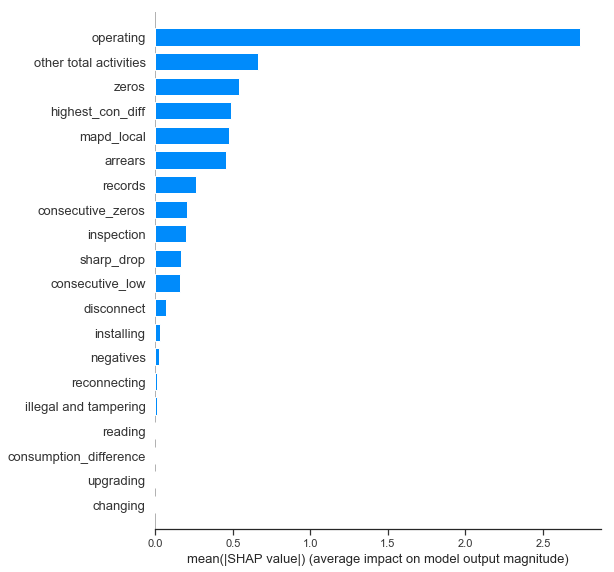

In [95]:
shap.summary_plot(shap_values, X.drop('id_uc', axis=1), plot_type="bar")


In [93]:
?shap.summary_plot

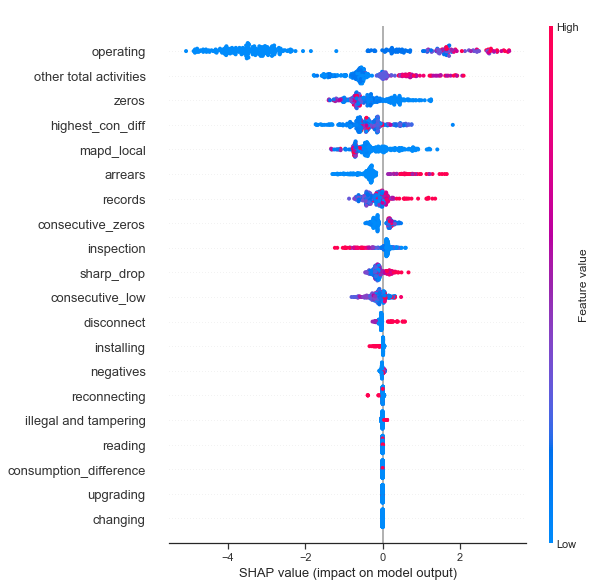

In [57]:
shap.summary_plot(shap_values, X.drop('id_uc', axis=1))


In [58]:
predictions_proba = model.predict(d_test) 
predictions = (model.predict(d_test) > 0.5).astype(int)

In [59]:
predictions

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0])

In [60]:
true = np.array(y_test)

In [61]:
print(classification_report(true, predictions))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97        60
           1       0.88      0.70      0.78        10

   micro avg       0.94      0.94      0.94        70
   macro avg       0.91      0.84      0.87        70
weighted avg       0.94      0.94      0.94        70



In [62]:
print(f"F1-Score is {f1_score(true, predictions)}")
print(f"Precision is {precision_score(true, predictions)}")
print(f"Recall is {recall_score(true, predictions)}")
print(f"ROC AUC score is {roc_auc_score(true, predictions)}")

F1-Score is 0.7777777777777777
Precision is 0.875
Recall is 0.7
ROC AUC score is 0.8416666666666667


In [63]:
data = confusion_matrix(true, predictions)

df_cm = pd.DataFrame(data, columns=np.unique(true), index = np.unique(true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,4))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size

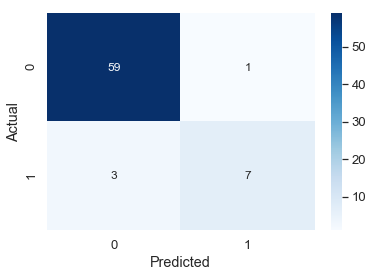

In [64]:
df_cm = pd.DataFrame(data, columns=np.unique(true), index = np.unique(true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,4))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size

## Use SHAP to investigate the false negatives and true positives

In [65]:
summary_pred = pd.DataFrame()
summary_pred['true'] = true
summary_pred['prediction'] = predictions
summary_pred['predict_proba'] = predictions_proba

In [66]:
X_test_cp = X_test_cp.reset_index(drop=True)

In [67]:
X_test_cp['true'] = pd.Series(list(true))
X_test_cp['prediction'] = pd.Series(list(predictions))
X_test_cp['predict_proba'] = pd.Series(list(predictions_proba))


### List of false negatives

In [68]:
false_negatives = (X_test_cp['true']==1 ) & (X_test_cp['prediction']==0 )

false_negatives_list = list(X_test_cp[false_negatives]['id_uc'])

In [69]:
probas_list = list(X_test_cp[false_negatives]['predict_proba'])

In [70]:
probas_list

[0.15988095104694366, 0.07260533422231674, 0.43920931220054626]

In [71]:
X[X['id_uc'].isin(false_negatives_list)]

id_uc  records  negatives     zeros  consecutive_zeros  \
108  100003441514     81.0   0.000000  0.086420           0.012346   
176  100004532229     19.0   0.000000  0.052632           0.052632   
187  100004621524     34.0   0.058824  0.088235           0.058824   

     consumption_difference  sharp_drop  consecutive_low  highest_con_diff  \
108                     0.0    0.049383         0.012346          0.555783   
176                     0.0    0.052632         0.052632          2.111485   
187                     0.0    0.117647         0.058824          1.881065   

     mapd_local    ...      jamming  missing  no display  operating  \
108    0.618600    ...          0.0      0.0         0.0        4.0   
176    0.195766    ...          0.0      0.0         0.0        3.0   
187    0.000000    ...          0.0      0.0         0.0        1.0   

     other total activities  reading  reconnecting  replacing  testing  \
108                     0.0      0.0           0.0        0.0      0.0   
176                     0.0      0.0           0.0        0.0      0.0   
187                     6.0      0.0           0.0        0.0      0.0   

     upgrading  
108        0.0  
176        0.0  
187        0.0  

[3 rows x 27 columns]

In [72]:
data_source_dir

'K:\\Projects\\sarawak_energy\\data'

In [73]:
i=108
shap.force_plot(explainer.expected_value, shap_values[i,:], X.drop('id_uc', axis=1).iloc[i,:])

In [74]:
i=176
shap.force_plot(explainer.expected_value, shap_values[i,:], X.drop('id_uc', axis=1).iloc[i,:])

In [75]:
i=187
shap.force_plot(explainer.expected_value, shap_values[i,:], X.drop('id_uc', axis=1).iloc[i,:])

# UPDATE SHAP to 0.31

## TODO

Come up with prediction probability to highlight very borderline effect

### List of false positives

In [76]:
false_positives = (X_test_cp['true']==0 ) & (X_test_cp['prediction']==1 )

false_positives_list = list(X_test_cp[false_positives]['id_uc'])

In [77]:
probas_list = list(X_test_cp[false_positives]['predict_proba'])

In [78]:
X_test_cp[false_positives]

id_uc  records  negatives     zeros  consecutive_zeros  \
18  100000597035    129.0        0.0  0.449612           0.224806   

    consumption_difference  sharp_drop  consecutive_low  highest_con_diff  \
18                     0.0    0.007752         0.007752          2.042415   

    mapd_local      ...        operating  other total activities  reading  \
18         0.0      ...              1.0                     8.0      0.0   

    reconnecting  replacing  testing  upgrading  true  prediction  \
18           0.0        0.0      0.0        0.0     0           1   

    predict_proba  
18       0.531271  

[1 rows x 30 columns]

In [79]:
probas_list

[0.5312706828117371]

In [80]:
sns.set_style('white')

In [81]:
i=4
shap.force_plot(explainer.expected_value, shap_values[i,:], X.drop('id_uc', axis=1).iloc[i,:])

## xgb.train cross validation

* Using xgb.train for cross validation

In [82]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from scipy import interp

In [83]:
X_imp = X.replace(np.NaN, 0)

In [84]:
params

{'eta': 0.01,
 'objective': 'binary:logistic',
 'max_depth': 7,
 'eval_metric': 'logloss',
 'scale_pos_weight': 6.142857142857143,
 'n_jobs': -1,
 'silent': 1,
 'seed': 2147}

In [85]:
xgb_results = {}

cv = StratifiedKFold(shuffle=True, random_state=2147, n_splits=5)

f1_scores_list = []
auc_scores_list = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, y_train = X_imp.iloc[train_idx], y[train_idx]
    X_test, y_test = X_imp.iloc[test_idx], y[test_idx]
    
    # Uncomment for using SMOTE
    #X_train, y_train = SMOTE().fit_sample(X_train, y_train)
    #X_train = pd.DataFrame(X_train, columns = X.columns)
    #y_train = pd.Series(y_train)
    
    d_train = xgb.DMatrix(X_train.drop('id_uc', axis=1), label=y_train)
    d_test = xgb.DMatrix(X_test.drop('id_uc', axis=1), label=y_test)
    
    model_xgb = xgb.train(params, d_train, 1000, evals = [(d_train, "train"), (d_test, "test")], verbose_eval=0, early_stopping_rounds=100, evals_result=xgb_results)
    predictions = (model_xgb.predict(d_test) > 0.5).astype(int)
    true = np.array(y_test)
    
    
    
    f1_scores_list.append(f1_score(true, predictions))
    auc_scores_list.append(roc_auc_score(true, predictions))
    #print(f"F1-Score for fold {fold+1} is {f1_score(true, predictions)}")

In [86]:
f1_scores_list

[0.8000000000000002,
 0.9,
 0.8235294117647058,
 0.8181818181818182,
 0.7000000000000001]

In [87]:
print(f"Mean F1-Score is {np.mean(f1_scores_list)}")
print(f"Mean AUC is {np.mean(auc_scores_list)}")

Mean F1-Score is 0.8083422459893048
Mean AUC is 0.8911657559198541


## sklearn cross_val_predict
* Using xgb.XGBClassifier and sklearn cross_val_score
* Should produce similar results as above

In [88]:
params_2 = params.copy()

In [89]:
params_2.update({'n_estimators': 1000,
                'early_stopping_rounds': 100
                })

In [90]:
xgb_clf = xgb.XGBClassifier(**params_2)

In [98]:
f1_scores_full = cross_val_score(xgb_clf, X.drop(['id_uc'], axis=1), y, cv = StratifiedKFold(shuffle=True, random_state=2148, n_splits=5), scoring='f1',n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


In [100]:
auc_scores_full = cross_val_score(xgb_clf, X.drop(['id_uc'], axis=1), y, cv = StratifiedKFold(shuffle=True, random_state=2148, n_splits=5), scoring='roc_auc',n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


In [101]:
print(f"Avg F1-Score is: {np.mean(f1_scores_full)}")
print(f"Avg AUC is: {np.mean(auc_scores_full)}")

Avg F1-Score is: 0.7897911445279866
Avg AUC is: 0.9512185792349728


# Data that could help improve the model

* Credit worthiness ranking of customer - payment performance, income, etc all in a single score
* Smart meter load profile of customer - enable changepoint detection
* More fraud data 
* Past fraud data

# Saving Prediction File

In [106]:
X.shapX_train.drop('id_uc', axis=1, inplace=True)
X_test.drop('id_uc', axis=1, inplace=True)
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

(350, 27)

In [108]:
X_dmatrix = xgb.DMatrix(X.drop(['id_uc'], axis=1), label=y)

In [110]:
X_predict_proba = model.predict(X_dmatrix)

In [116]:
X_predictions = (X_predict_proba > 0.5).astype(int)

In [121]:
confusion_matrix(y, X_predictions)

array([[300,   1],
       [  3,  46]], dtype=int64)

In [123]:
X_output = X.copy(deep=True)

In [126]:
X_output['actual'] = y
X_output['predicted'] = X_predictions
X_output['predictions_proba'] = X_predict_proba

In [128]:
X_output.to_csv(r'K:\Projects\sarawak_energy\viz\cleansed_df_predictions.csv', index=False)